# Inference - Small

This notebook gives you a brief tutorial to help you understand the simple machine learning 
inference used for this project.  

It creates a home-made neural network, and uses it to evaluate a 1000 sample set of the MNIST dataset

It also times and profiles the executed code. 

In [1]:
%matplotlib inline
import cProfile
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import truncnorm
import timeit

In [2]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "./data/"

## Load and visualize the data

In [3]:
test_data = pd.read_csv(data_path + "mnist_test.1k.csv", delimiter=",").values

fac = 0.99 / 255
test_imgs = np.asfarray(test_data[:, 1:], dtype=np.float32) * fac + 0.01
test_imgs = test_imgs.reshape(test_imgs.shape[0], 1, test_imgs.shape[1])

test_labels = np.asfarray(test_data[:, :1], dtype=np.float32)

lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
test_labels_one_hot = (lr==test_labels).astype(np.float32)

# we don't want zeroes and ones in the labels neither:
test_labels_one_hot[test_labels_one_hot==0] = 0.001
test_labels_one_hot[test_labels_one_hot==1] = 0.999

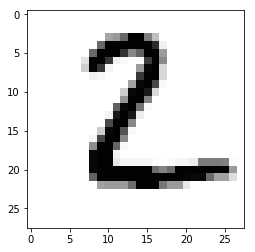

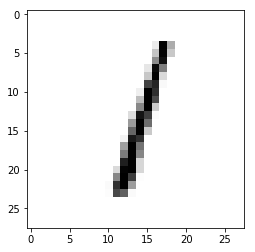

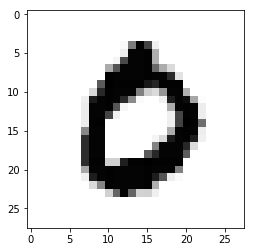

In [4]:
for i in range(3):
    img = test_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

## Machine Learning Model

Based on: https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

In [5]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [6]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [7]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [8]:
class TanhLayer(ActivationLayer):
    # static
    e = 2.71828182845904523536028747135266249775724709369995
    
    #http://www.plunk.org/~hatch/rightway.php
    #https://math.stackexchange.com/questions/518758/alternative-form-for-sinhx-coshx
    @staticmethod
    def tanh(x):   
        e = TanhLayer.e
        return (1 - e ** (-2 * x)) / (1 + e ** (-2 * x)) 
        #return (1-np.exp(-2 * x))/(1+np.exp(-2 * x))

    @staticmethod
    def tanh_prime(x):
        return 1-TanhLayer.tanh(x)**2
    
    def __init__(self):
        super(TanhLayer,self).__init__(self.tanh, self.tanh_prime)
    

In [9]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [10]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
    
    def save(self, fname):
        import pickle
        with open(fname, "bw") as fh:
            pickle.dump(self, fh)

    @classmethod
    def load(cls, fname):
        import pickle
        with open(fname, "br") as fh:
            return pickle.load(fh)

## Let's load the Neural Network and the weight file.  

If you are interested, the weights can be (re)generated using the "Train" Notebook in this same folder.  
We recommend doing this on your laptop **NOT** your Pynq!

In [11]:
net = Network.load('network.pkl')

## Now we test it on the 3 samples above

Index: 0
Image:


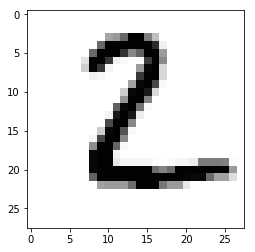

ML Predictions: 
	0: 0.010
	1: 0.002
	2: 0.991
	3: 0.009
	4: -0.004
	5: 0.008
	6: -0.005
	7: 0.003
	8: -0.008
	9: -0.002
ML Classification Result: 2
Real Value: 2
Correct Result: True

Index: 1
Image:


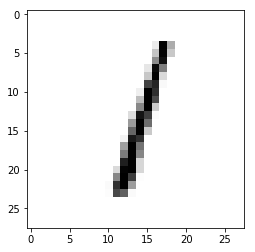

ML Predictions: 
	0: 0.004
	1: 0.993
	2: 0.006
	3: -0.001
	4: 0.003
	5: 0.005
	6: 0.001
	7: -0.000
	8: -0.001
	9: 0.002
ML Classification Result: 1
Real Value: 1
Correct Result: True

Index: 2
Image:


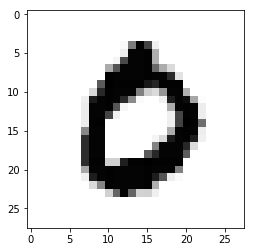

ML Predictions: 
	0: 1.004
	1: 0.003
	2: -0.002
	3: 0.001
	4: 0.002
	5: -0.000
	6: -0.002
	7: -0.002
	8: 0.001
	9: 0.003
ML Classification Result: 0
Real Value: 0
Correct Result: True



In [12]:
for i in range(3):
    predictions = np.array(net.predict(test_imgs[i])[0][0])
    ml_number = predictions.argmax()
    real_number = int(test_labels[i][0])
    match = (ml_number == real_number)
    img = test_imgs[i].reshape((28,28))
    
    predictions = list(map(lambda x,y: str(x) + ': ' + "{:1.3f}".format(y), \
                               range(0,10), predictions))
    
    print ("===============================")
    print ('Index: ' + str(i))
    print ('Image:')
    plt.imshow(img, cmap="Greys")
    plt.show()
    print ('ML Predictions: \n\t' + '\n\t'.join(predictions))
    print ('ML Classification Result: ' + str(ml_number) )
    print ('Real Value: ' + str(real_number))
    print ('Correct Result: ' + str(match))
    print ("===============================")
    print ()




## Here's one that is NOT correctly classified

Index: 7
Image:


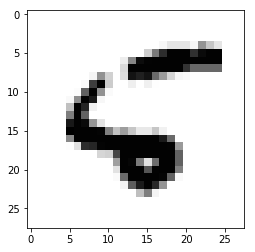

ML Predictions: 
	0: 0.019
	1: 0.020
	2: 0.028
	3: 0.029
	4: 0.065
	5: 0.088
	6: 0.717
	7: 0.006
	8: 0.024
	9: 0.012
ML Classification Result: 6
Real Value: 5
Correct Result: False



In [13]:
for i in range(0,10):
    predictions = np.array(net.predict(test_imgs[i])[0][0])
    ml_number = predictions.argmax()
    real_number = int(test_labels[i][0])
    match = (ml_number == real_number)
    img = test_imgs[i].reshape((28,28))
    
    predictions = list(map(lambda x,y: str(x) + ': ' + "{:1.3f}".format(y), \
                               range(0,10), predictions))
    if (match == False): 
        print ("===============================")
        print ('Index: ' + str(i))
        print ('Image:')
        plt.imshow(img, cmap="Greys")
        plt.show()
        print ('ML Predictions: \n\t' + '\n\t'.join(predictions))
        print ('ML Classification Result: ' + str(ml_number) )
        print ('Real Value: ' + str(real_number))
        print ('Correct Result: ' + str(match))
        print ("===============================")
        print ()
    

## Now let's run all the test images

In [14]:
def evaluate(net, data, labels):
    corrects, wrongs = 0, 0
    for i in range(len(data)):
        res = np.array(net.predict(data[i]))
        res = res.argmax()
        if res == labels[i]:
            corrects += 1
        else:
            wrongs += 1
    return corrects, wrongs

In [15]:
corrects, wrongs = evaluate(net, test_imgs, test_labels)
print ("Total Correct:" + str(corrects))
print ("Total Incorrect: " + str(wrongs))
print("Overall Accruracy: " + str(corrects / ( corrects + wrongs)))
print("Overall Accruracy (%): " + str( int( 1000* corrects / ( corrects + wrongs)) / 10) + "%")

Total Correct:954
Total Incorrect: 46
Overall Accruracy: 0.954
Overall Accruracy (%): 95.4%


## That's 95.4% accuracy across 1000 test images

## Now let's start timing things

In [16]:
start = timeit.default_timer()

corrects, wrongs = evaluate(net, test_imgs, test_labels)

stop = timeit.default_timer()
print('Run Time: ' + str(stop - start) + ' Seconds')  

Run Time: 0.08978786700000008 Seconds


## Now let's try running a "profiler" on our ML code

In [17]:
cProfile.run('evaluate(net, test_imgs, test_labels)')

         19005 function calls in 0.088 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.004    0.000    0.079    0.000 <ipython-input-10-3212fe1b67fb>:17(predict)
        1    0.005    0.005    0.088    0.088 <ipython-input-14-db1a90a85f22>:1(evaluate)
     4000    0.010    0.000    0.034    0.000 <ipython-input-6-76f0cbafedc7>:10(forward_propagation)
     3000    0.002    0.000    0.041    0.000 <ipython-input-7-ae91a1e2165d>:8(forward_propagation)
     3000    0.039    0.000    0.039    0.000 <ipython-input-8-376feb2ad2c4>:7(tanh)
        1    0.000    0.000    0.088    0.088 <string>:1(<module>)
        1    0.000    0.000    0.088    0.088 {built-in method builtins.exec}
     1001    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     1000    0.003    0.000    0.003    0.000 {built-in method numpy.array}
     4000    0.024    0.000    0.024    0.000 {built-in method numpy.dot}
     1000   

In [18]:
cProfile.run('evaluate(net, test_imgs, test_labels)', 'test.cprof')

### You can now use a variety of profile analysis tools to visualize 'test.cprof'.

Here's one from a visualizer named 'SnakeViz'.  This was generated running on my Macbook.    

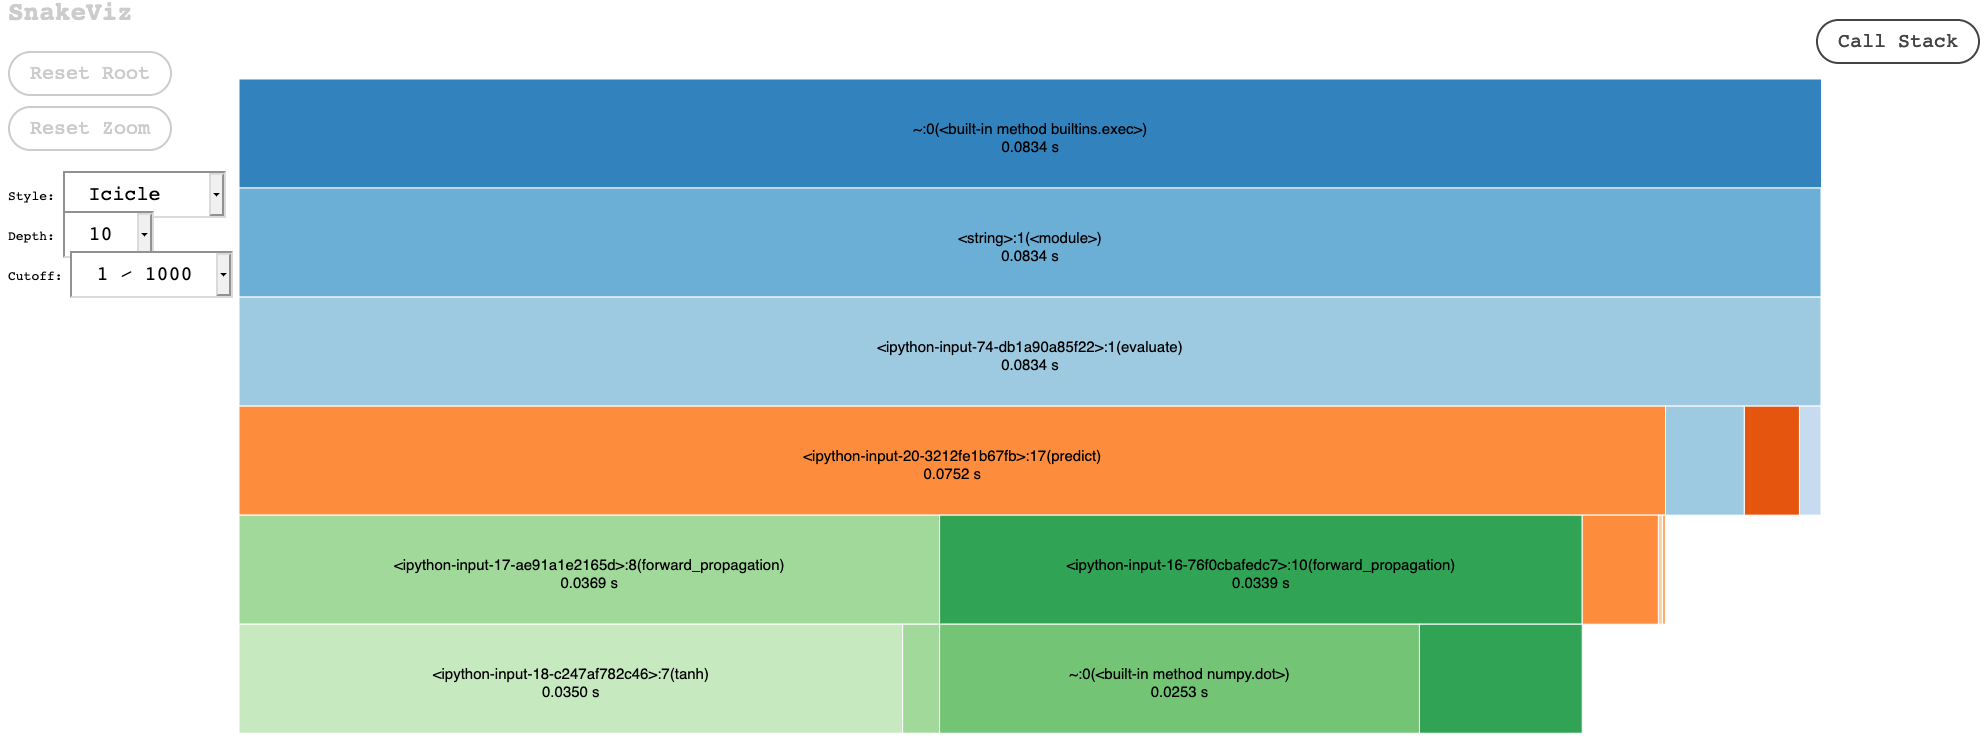

And here's that same data but run on the Pynq.  Everything stays roughly the same, but the runtimes get longer. 

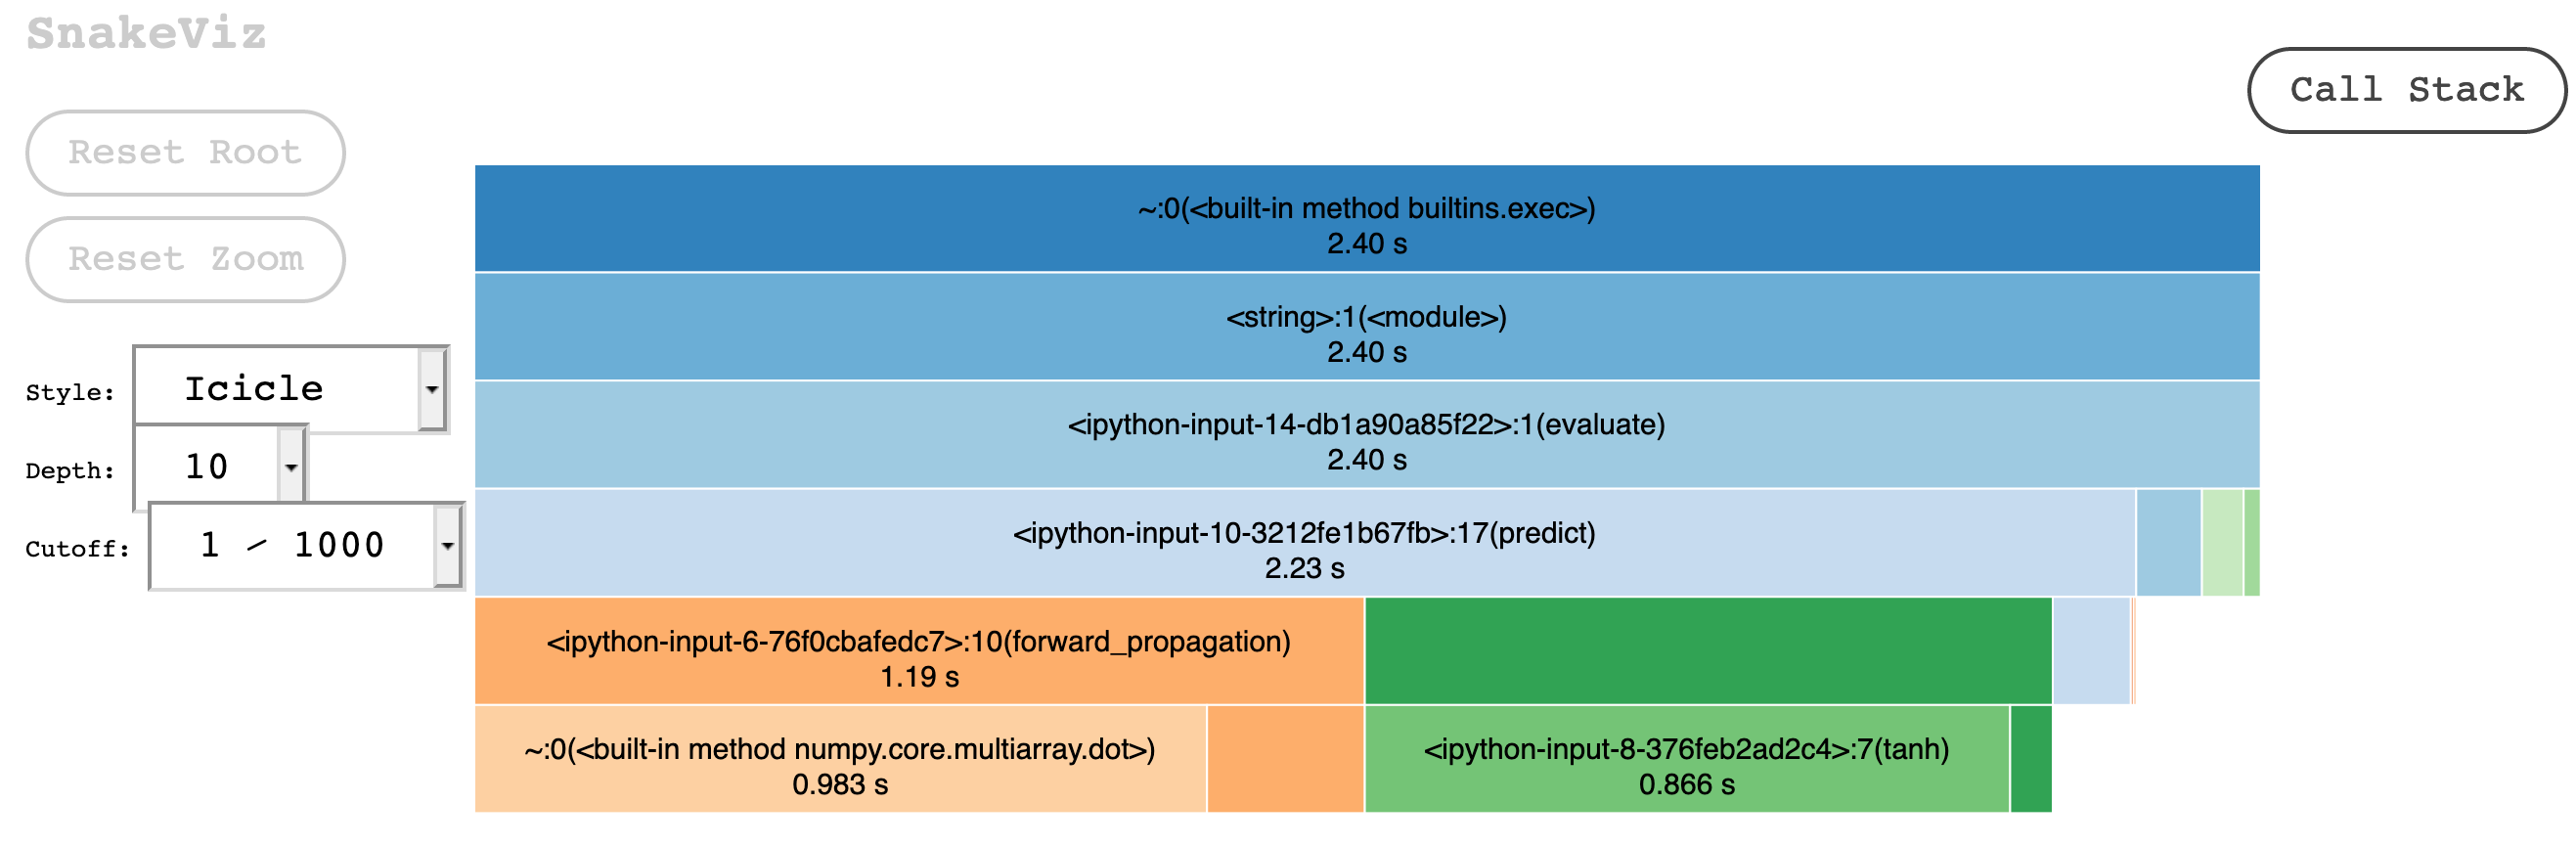

# We can also update layers as needed

## Let's define a new Tanh layer using NumPy

In [19]:
# This layers redefines Tanh using Python's NumPy math functions
class NpTanhLayer(ActivationLayer):
        
    def __init__(self):
        super(NpTanhLayer,self).__init__(self.tanh, self.tanh_prime)
        # could also do
        #super(NpTanhLayer,self).__init__(np.tanh, self.tanh_prime)
        
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    # another option:
    # tanh = np.tanh
    
    @staticmethod
    def tanh_prime(x):        
        return 1-np.tanh(x)**2; 

## And swap it in for our old Tanh layer

In [27]:
net2 = Network.load('network.pkl')

for i in range(len(net2.layers)):
    l = net2.layers[i]
    is_tanh = isinstance(l, TanhLayer)
    print ("Index: " + str(i))
    print ("Layer Name: " + str(l.__class__.__name__))
    print ("Layer is Tanh: " + str(is_tanh))
    if is_tanh:
        print ("Replacing Tanh with NpTanh")
        net2.layers[i] = NpTanhLayer()
    print ()

Index: 0
Layer Name: FCLayer
Layer is Tanh: False

Index: 1
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with NpTanh

Index: 2
Layer Name: FCLayer
Layer is Tanh: False

Index: 3
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with NpTanh

Index: 4
Layer Name: FCLayer
Layer is Tanh: False

Index: 5
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with NpTanh

Index: 6
Layer Name: FCLayer
Layer is Tanh: False



## Now let's see what that did to our accuracy and runtime

In [21]:
corrects, wrongs = evaluate(net2, test_imgs, test_labels)
print ("Total Correct:" + str(corrects))
print ("Total Incorrect: " + str(wrongs))
print("Overall Accruracy: " + str(corrects / ( corrects + wrongs)))
print("Overall Accruracy (%): " + str( int( 1000* corrects / ( corrects + wrongs)) / 10) + "%")

Total Correct:954
Total Incorrect: 46
Overall Accruracy: 0.954
Overall Accruracy (%): 95.4%


In [22]:
start = timeit.default_timer()

corrects, wrongs = evaluate(net2, test_imgs, test_labels)

stop = timeit.default_timer()
print('Run Time: ' + str(stop - start) + ' Seconds')  

Run Time: 0.04379152799999986 Seconds
